### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
%matplotlib inline
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

### Load the dataset

***Dataset description: The dataset contains sales record of 50 different items sold through 10 stores from the year 2013 to 2017***

In [2]:
df = pd.read_csv(r'C:\Users\nikhi\Downloads\data\train.csv')
df

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10
...,...,...,...,...
912995,12/27/2017,10,50,63
912996,12/28/2017,10,50,59
912997,12/29/2017,10,50,74
912998,12/30/2017,10,50,62


### Check for missing values

In [3]:
df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

There are no missing values in the dataset

## Data preprocessing

In [4]:
#Changing date to datetime object 
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

#Adding columns to hold year, month, and day seperately
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

### Separating sales record of Item 50 sold at Store 1

In [5]:
item1 = df[df['item'] == 50]
item1 = item1[item1['store'] == 1]
item1

,date,store,item,sales,year,month,day,weekday
894740,2013-01-01,1,50,30,2013,1,1,1
894741,2013-01-02,1,50,32,2013,1,2,2
894742,2013-01-03,1,50,25,2013,1,3,3
894743,2013-01-04,1,50,32,2013,1,4,4
894744,2013-01-05,1,50,35,2013,1,5,5
...,...,...,...,...,...,...,...,...
896561,2017-12-27,1,50,38,2017,12,27,2
896562,2017-12-28,1,50,52,2017,12,28,3
896563,2017-12-29,1,50,59,2017,12,29,4
896564,2017-12-30,1,50,66,2017,12,30,5


In [6]:
#Splitting the training and testing data
#train: 2013-01-01 to 2017-09-30
#test: 2017-10-01 to 2017-12-31 (last three months)

temp_item1 = item1.set_index('date')
train_item1 = temp_item1.loc[:'2017-09-30'].reset_index(drop=False)                         
test_item1 = temp_item1.loc['2017-10-01':].reset_index(drop=False)

In [7]:
train_item1.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,50,30,2013,1,1,1
1,2013-01-02,1,50,32,2013,1,2,2
2,2013-01-03,1,50,25,2013,1,3,3
3,2013-01-04,1,50,32,2013,1,4,4
4,2013-01-05,1,50,35,2013,1,5,5


In [8]:
test_item1.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,50,66,2017,10,1,6
1,2017-10-02,1,50,47,2017,10,2,7
2,2017-10-03,1,50,55,2017,10,3,1
3,2017-10-04,1,50,67,2017,10,4,2
4,2017-10-05,1,50,50,2017,10,5,3


### Exploring data of Item

***Plotting the weekly, monthly and yearly sales distribution of item and finding patterns in the data and deriving useful insights***

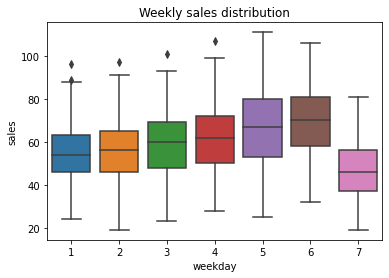

In [9]:
#Weekly sales distribution
plot = sn.boxplot(x='weekday', y='sales', data=item1)
_ = plot.set(title='Weekly sales distribution')

**Inference:** The sales show an increase from Tuesday(2) and show peak on Saturday(6). The sales falls drastically on Sunday(7)

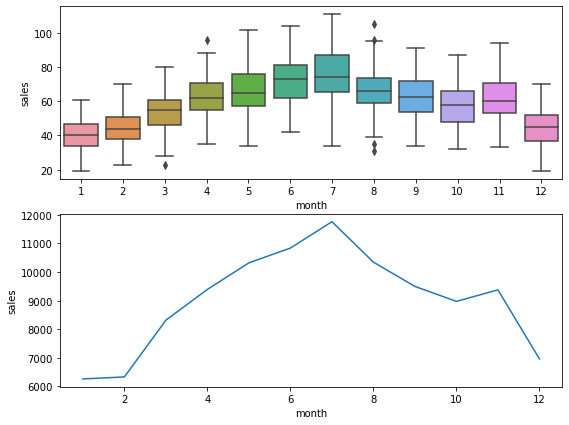

In [10]:
#Monthly sales distribution
monthly_agg = item1.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=item1, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

**Inference:** The sales show a steady increase from January(1) to July(7) after which the sales decrease till October(10). The sales slightly increrase during November(11) but decline again during December(12).

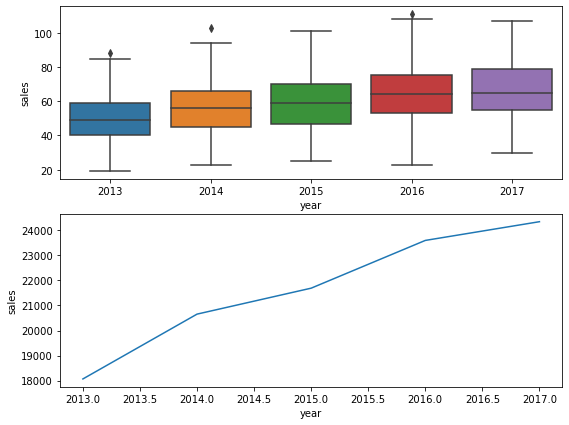

In [11]:
#Yearly sales distribution
yearly_agg = item1.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=item1, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

**Inference:** Sales show growth with passing every year. From 18000 in the year 2013 to 24000 by the year 2017, there is **33.3% increase** in the sales. 

## Data Modelling

### Model 1: Seasonal Naive

The seasonal naive method considers the data that occurred at the same time last period and predicts that the same will happen again. Since the test dataset holds values from October 2017 to December 2017, this method will refer to the time from October 2016 to December 2016 to project the outputs.

Keeping the seasonality in mind the naive forecasts will be based on the sales distribution of the item from a year ago.

In [12]:
# Removing one year from test data
dates = (test_item1['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 
seasonal_naive_sales = train_item1[train_item1['date'].astype('datetime64[D]').isin(dates)]['sales'] 

# make a copy of the test_item1 and make naive predictions for the last 3 months of 2017
sn_pred_item1 = test_item1.copy().drop('sales', axis=1)
sn_pred_item1['seasonal_naive_sales_ITEM1'] = pd.DataFrame(seasonal_naive_sales).set_index(test_item1.index)
sn_pred_item1.head()

,date,store,item,year,month,day,weekday,seasonal_naive_sales_ITEM1
0,2017-10-01,1,50,2017,10,1,6,60
1,2017-10-02,1,50,2017,10,2,7,68
2,2017-10-03,1,50,2017,10,3,1,40
3,2017-10-04,1,50,2017,10,4,2,69
4,2017-10-05,1,50,2017,10,5,3,64


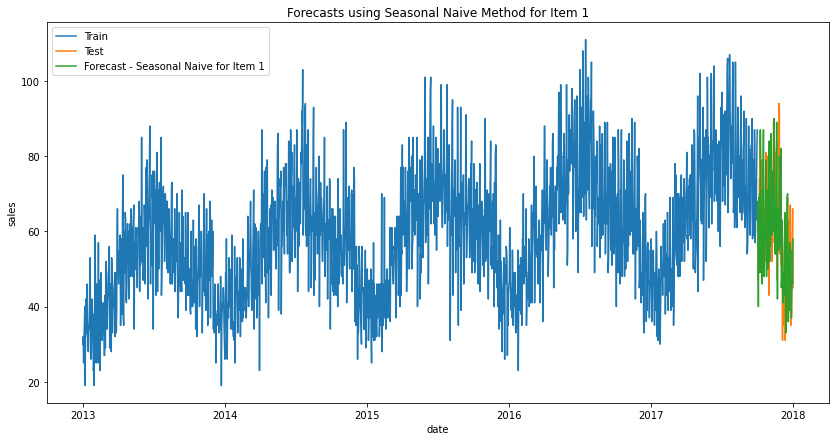

In [13]:
#Plotting the prediction made by the Seasonal Naive method
plt.figure(figsize=(14,7))
plt.plot(train_item1['date'], train_item1['sales'], label='Train')
plt.plot(test_item1['date'], test_item1['sales'], label='Test')
plt.plot(sn_pred_item1['date'], sn_pred_item1['seasonal_naive_sales_ITEM1'], label='Forecast - Seasonal Naive for Item 1')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal Naive Method for Item 1')
plt.show()

**Inference:** There is a visible seasonal pattern in the sales which is repeated every year from 2013 to 2017. The sales increase from January to July and then then decrease between August to December with a slight increase in the month of November.

### Computing the error in the forecast of Model 1

The forecast error = Expected value - Predicted value

- **MAE(Mean Absolute Error):** mean of the difference between expected and predicted value i.e., the sum of error divided by number of observations


- **RMSE(Root Mean Square error):** the square root of the mean of the square of all the error


- **MAPE(Mean Absolute Percentage Error):** the only scale independent metric out of the three, it is the division of the sum of the absolute error by the sum of actual sales to get a percentage indicator that is scaled to the actual sales.

In [14]:
errors_item1 = pd.merge(test_item1, sn_pred_item1, on='date')
errors_item1 = errors_item1[['date', 'sales', 'seasonal_naive_sales_ITEM1']]
errors_item1 = pd.merge(test_item1, sn_pred_item1, on='date')
errors_item1 = errors_item1[['date', 'sales', 'seasonal_naive_sales_ITEM1']]
errors_item1['errors'] = test_item1['sales'] - sn_pred_item1['seasonal_naive_sales_ITEM1']
errors_item1.insert(0, 'model', 'Seasonal Naive for Item 1') 

#mean absolute error
def mae(err):
    return np.mean(np.abs(err))

#root mean squared error
def rmse(err):
    return np.sqrt(np.mean(err ** 2))

#mean absolute percentage error
def mape(err, sales=errors_item1['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_item1 = errors_item1.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales_ITEM1', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae), 
                                           RMSE=('errors', rmse), 
                                           MAPE=('errors', mape))

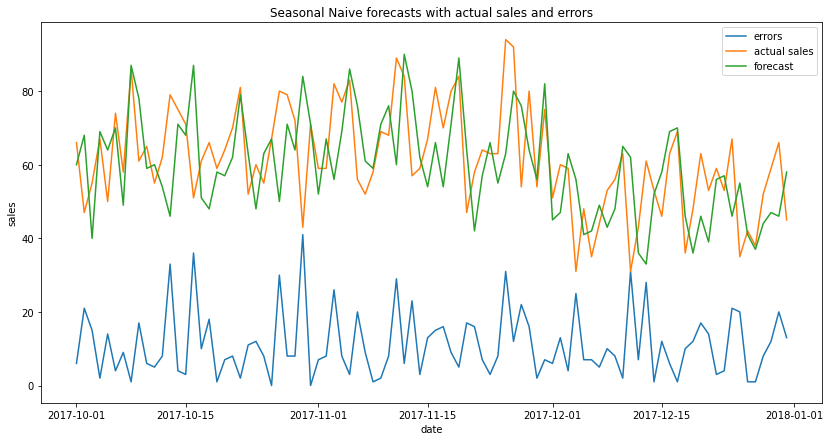

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive for Item 1,5662,5503,159,11.184783,14.385606,18.17379


In [15]:
plt.figure(figsize=(14,7))

plt.plot(errors_item1['date'], np.abs(errors_item1['errors']), label='errors')
plt.plot(errors_item1['date'], errors_item1['sales'], label='actual sales')
plt.plot(errors_item1['date'], errors_item1['seasonal_naive_sales_ITEM1'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_item1

The value of Mean Absolute Percentage Error (MAPE) for the prediction is **18.17%**.

Thus 18.17% computed error of the Seasonal Naive model will now be used as benchmark to determine the accuracy of the models further to be applied

### Time Series Decomposition Model

The purpose of a time series decomposition model is to observe the systematic components (levels, trends and seasonality) and the non-systematic component residual (noise/error) where trend, seasonality and residue play a major role in the exponential smoothing model.

In [16]:
#setting date as the index
ts_decomp_item1 = train_item1.set_index('date')
ts_decomp_item1['sales'] = ts_decomp_item1['sales'].astype(float)
ts_decomp_item1.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,50,30.0,2013,1,1,1
2013-01-02,1,50,32.0,2013,1,2,2
2013-01-03,1,50,25.0,2013,1,3,3
2013-01-04,1,50,32.0,2013,1,4,4
2013-01-05,1,50,35.0,2013,1,5,5


<Figure size 432x288 with 0 Axes>

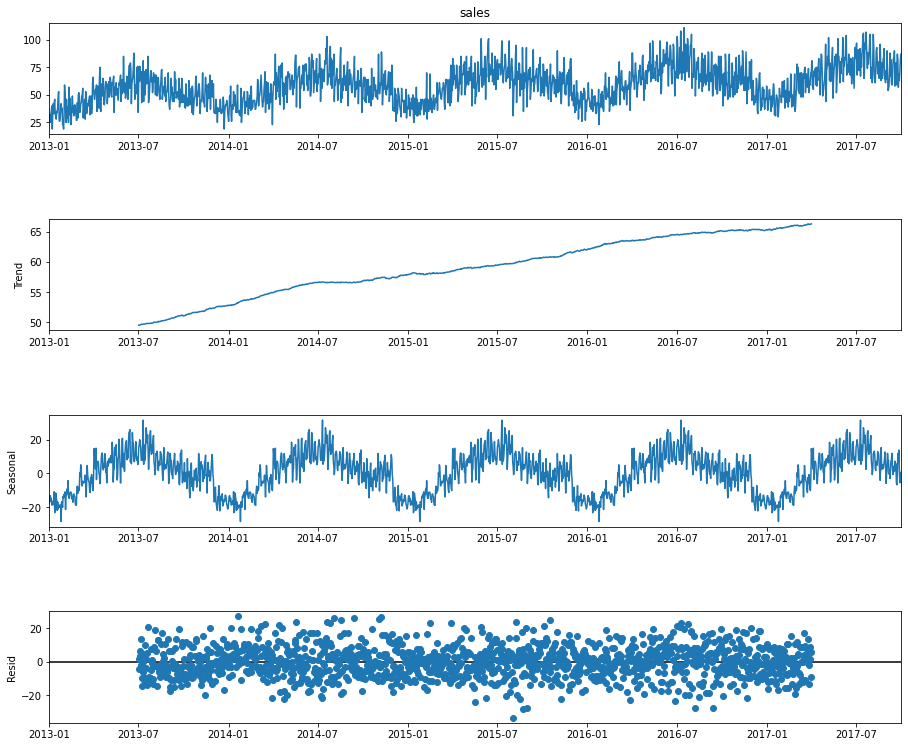

In [17]:
result = seasonal_decompose(ts_decomp_item1['sales'], model='additive', period=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

### Trend, Seasonality and Error

**1. TREND**: If the trend is plotted linearly then it implies it is additive (A), else if it either grows or shrinks exponentially then we multiply (M) it, or else when there is no certain trend then there is no trend component (N).

**2. SEASONALITY**: When the peaks and valleys plotted for seasonality are constant over time then we apply additively (A), if the size fluctuations in seasonality is increasing or decreasing with the time series then we apply it multiplicatively (M), else if there is no seasonality observed then seasonality component is not applied (N).

**3. RESIDUAL**: When the residual values plotted over time follow a linear sequence, then we apply it additively (A). Else if there are fluctuations then we apply it multiplicatively (M).

From the Time Series Decomposition model of item 1, the following can be concluded: -
- The trend plot shows linear growth over time which means it is applied additively (A).
- There are constant fluctuations between the peaks and valleys in seasonality so it is applied additively (A).
- Residual values show a linear pattern hence they are also additive (A).

Since all the components in the time series is additive, the mathematical function for time series y(t) will be: -
- **y(t) = trend + seasonal + residue**

### Model 2: Holt Winter's Triple Exponential Smoothing Model

Since the three components, trend, seasonality, and residue are influencing the pattern in the sales distribution, hence the Holt-Winters triple exponential smoothing model is used here. This model considers the influence of the three components while predicting the values.

In [18]:
hw_train_item1 = train_item1[['date', 'sales']].set_index('date')
hw_test_item1 = test_item1[['date', 'sales']].set_index('date')

# Applying the Triple Exponential Smoothing (TES)
hw_model_1 = ExponentialSmoothing(hw_train_item1, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(use_boxcox=False, remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_item1.index[0], end=hw_test_item1.index[-1]), 
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_item1, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_fit_2 = hw_model_2.fit(use_boxcox=False, remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_item1.index[0], end=hw_test_item1.index[-1]), 
                       name='pred_sales').reset_index()

print('Predictions by model have been generated successfully')

Predictions by model have been generated successfully


#### [Without damping trend component]

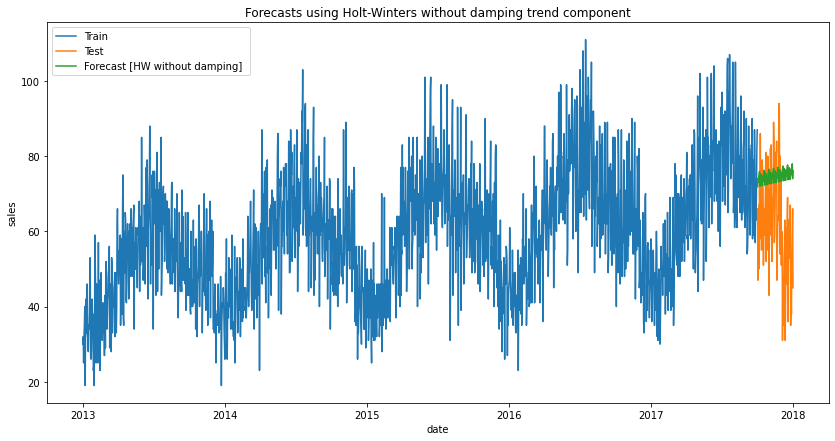

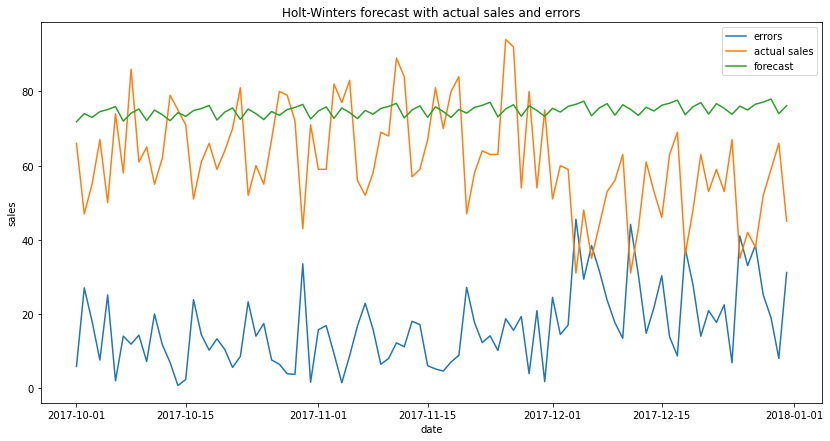

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,5662,6886.708389,-1224.708389,16.395407,19.423932,26.640364


In [19]:
#Combining the actual sales records and the predicted values into a single dataframe
errors_item1_hw = pd.merge(test_item1, pred_fit_1, left_on='date', right_on='index')
errors_item1_hw = errors_item1_hw[['date', 'sales', 'pred_sales']]
errors_item1_hw['errors'] = errors_item1_hw.sales - errors_item1_hw.pred_sales
errors_item1_hw.insert(0, 'model', 'Holt-Winters')

# Evaluating predictions for Holt-Winters with damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_item1['date'], train_item1['sales'], label='Train')
plt.plot(test_item1['date'], test_item1['sales'], label='Test')
plt.plot(errors_item1_hw['date'], errors_item1_hw['pred_sales'], label='Forecast [HW without damping] ')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_item1_hw['date'], np.abs(errors_item1_hw['errors']), label='errors')
plt.plot(errors_item1_hw['date'], errors_item1_hw['sales'], label='actual sales')
plt.plot(errors_item1_hw['date'], errors_item1_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecast with actual sales and errors')
plt.show()

result_item1_hw = errors_item1_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_item1_hw

The Holt Winter's TES model forecasts without damping the trend componenet resulted in **26.64% error**.

#### [With damping trend component]

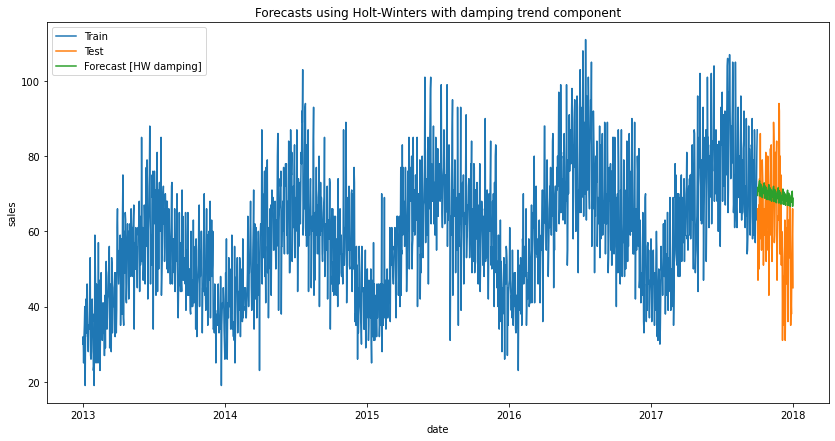

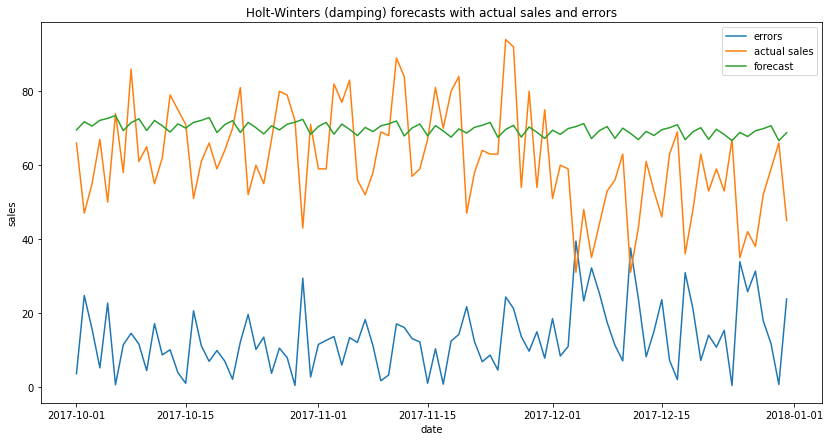

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,5662,6424.137874,-762.137874,13.290014,15.97529,21.594513


In [20]:
# Merge predictions and actual sales into one df
errors_item1_hwd = pd.merge(test_item1, pred_fit_2, left_on='date', right_on='index')
errors_item1_hwd = errors_item1_hwd[['date', 'sales','pred_sales']]
errors_item1_hwd['errors'] = errors_item1_hwd.sales - errors_item1_hwd.pred_sales
errors_item1_hwd.insert(0, 'model', 'Holt-Winters-Damped') 


# Evaluate the predictions for Holt-Winters with damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_item1['date'], train_item1['sales'], label='Train')
plt.plot(test_item1['date'], test_item1['sales'], label='Test')
plt.plot(errors_item1_hwd['date'], errors_item1_hwd['pred_sales'], label='Forecast [HW damping]')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_item1_hwd['date'], np.abs(errors_item1_hwd['errors']), label='errors')
plt.plot(errors_item1_hwd['date'], errors_item1_hwd['sales'], label='actual sales')
plt.plot(errors_item1_hwd['date'], errors_item1_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_item1_hwd = errors_item1_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_item1_hwd

The plotted forecast shows a slight decline in the sales of teh item and the computed error for the Holt Winter's with damping trend is **21.59%**. 

HW model with damping trend although resulted in a better accuracy as compared to the without damping model, but it isn't better than the benchmark of 18.17% by the previous model (Seasonal Naive).

### Model 3: ARIMA Model
### (AutoRegressive Integrated Moving Average)

Step 1 - Check stationarity

Step 2 - Differencing (if not stationary)

Step 3 - Building the model

### Check stationarity
Stationarity is used to define the data wherein the statistical properties like the variance, auto-corelation, etc remains constant over time. The need for stationarity arises since the forecasting model is dependent on this to make estimations.

It can be checked using the following ways:-
1. Plotting the rolling statistics
2. Augmented Dickey Fuller test
3. ACF & PACF

The rolling statistics analyzes the series of averages of data values in different subsets. Thus if the plot depicts a slope (either incline or decline), then that implies the data is not stationary.

The Augmented Dickey Fuller (ADF) test is applied to check the hypothesis and determine whether to reject the null hypothesis that the data is not stationary.

ACF (Auto-correlation function) and PACF (Partial Correlation function) plot is used to determine the AR (p) and MA (q) values.

ROLLING STATISTICS


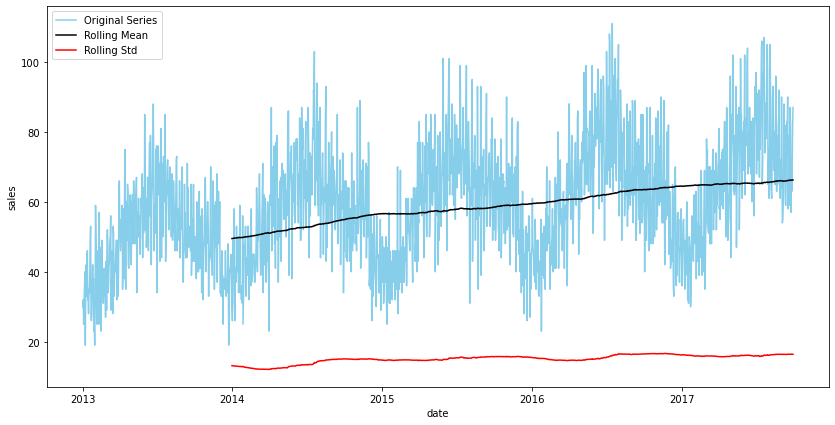

AUGMENTED DICKEY FULLER TEST

Test statistic = -2.722
P-value = 0.070
Critical values :
	1%: -3.434179908502461 - The data is not stationary with 99% confidence
	5%: -2.863231689892687 - The data is not stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


AUTO-CORRELATION PLOT


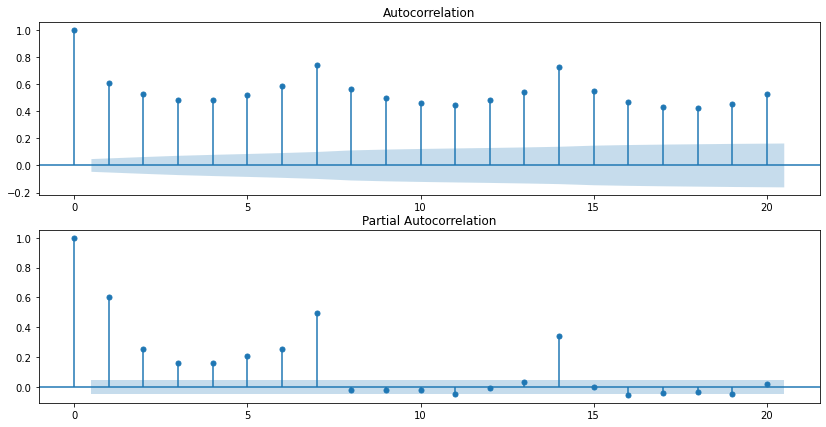

In [26]:
arima_item1 = train_item1[['date', 'sales']].set_index('date')
arima_test_item1 = test_item1[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    print("ROLLING STATISTICS")
    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    # Augmented Dickey Fuller (ADT) Test
    print("AUGMENTED DICKEY FULLER TEST\n")
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Auto-correlation plot
    print("\n\nAUTO-CORRELATION PLOT")
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_item1.sales)


Since the results show that the series is **not stationary**, we need to apply differencing to prepare it for ARIMA modeling.

### (ii) Apply differencing
Differencing is applied so as to remove the seasonality or any cyclic patterns which is done by removing the periodic values present in the data. 
Here, since the data shows seasonality every 12 months, the series should be subtracted by a 12 lag difference series thereby resulting in a flattened series. 

ROLLING STATISTICS


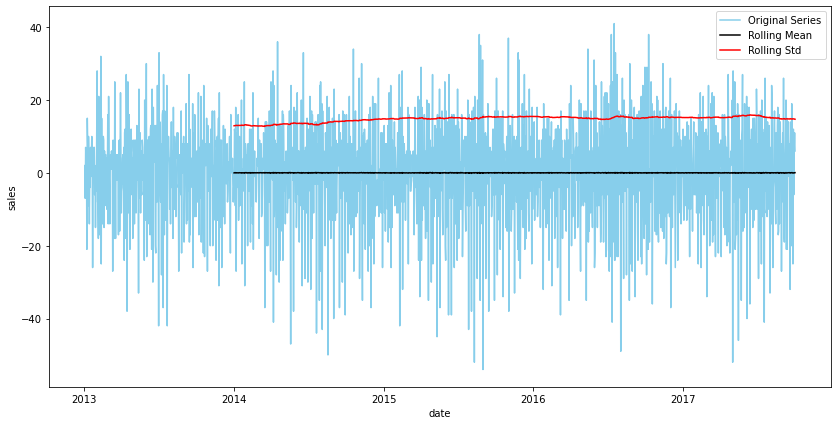

AUGMENTED DICKEY FULLER TEST

Test statistic = -10.576
P-value = 0.000
Critical values :
	1%: -3.434179908502461 - The data is  stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


AUTO-CORRELATION PLOT


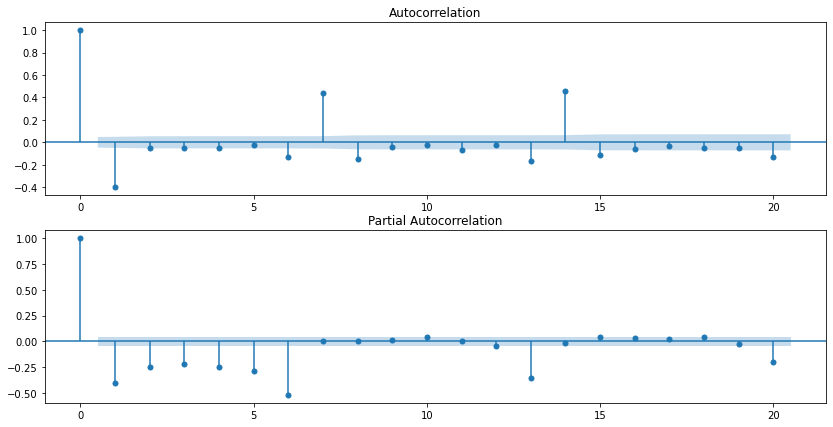

In [27]:
first_difference = arima_item1.sales - arima_item1.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))

#Checking stationarity after differencing
test_stationarity(first_difference.sales)

the stationarity is clearly visible through the plot after differencing telling the statistical values are now constant over time. Additionally since the test-statistics is less than the critical values, the **null hypothesis is rejected** concluding that the **data series is now stationary**.

We can now proceed to the data modelling using the ARIMA model.

### (iii) Building the ARIMA (pdq) model
Values of AR(p), I(d), MA(q)

AR (p) = number of auto-regressive terms
- The AR is significant in the forst 6 lags of PACF plot, p = 6

I (d) = number of non-seasonal differences required for stationarity
- The first order differencing made the time series stationary, d = 1

MA (q) = number of lagged forecasts error in the predictions
- A negative spike is observed at lag 1 in the ACF plot hence, q = 1

In [28]:
arima_model611 = ARIMA(arima_item1.sales, (6,1,1)).fit(disp=False)
print(arima_model611.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1733
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -6465.538
Method:                       css-mle   S.D. of innovations             10.085
Date:                Wed, 20 Jul 2022   AIC                          12949.075
Time:                        12:41:05   BIC                          12998.194
Sample:                    01-02-2013   HQIC                         12967.241
                         - 09-30-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0248      0.047      0.528      0.598      -0.067       0.117
ar.L1.D.sales    -0.8261      0.040    -20.785      0.000      -0.904      -0.748
ar.L2.D.sales    -0.7660      0.034    -

### Plotting residuls

If the residuals ploted using the ACF & PACF show similiarity then it signiifies the presence of seasonality in the data which in turn suggests that the Seasonal ARIMA (SARIMA) model is to be used.

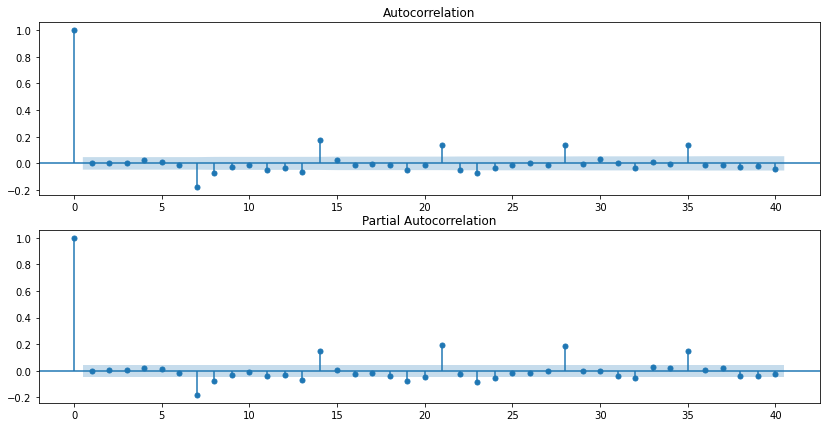

In [29]:
residuals = arima_model611.resid

# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

Since both the ACF and PACF plots clearly look similar, SARIMA model will be applied.

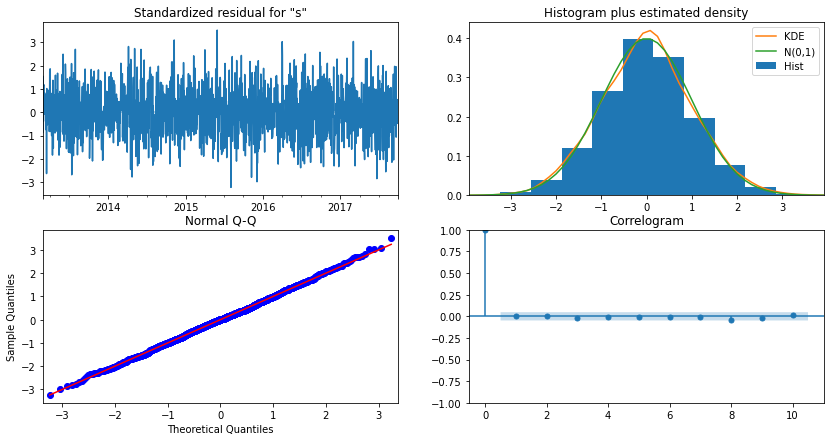

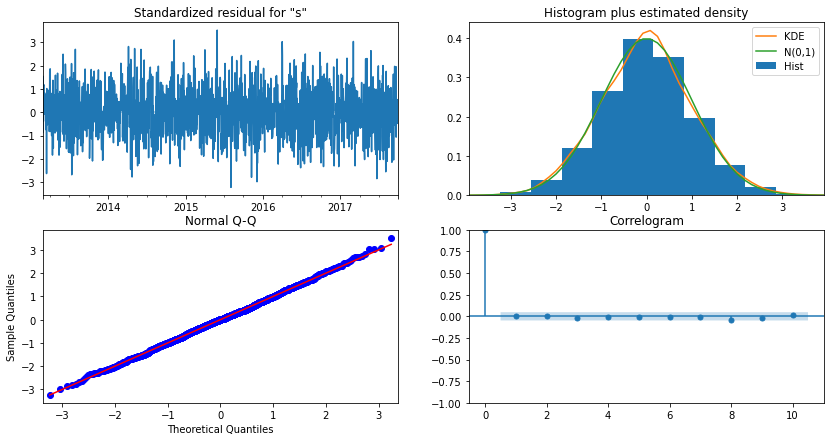

In [30]:
# fit SARIMA model
sarima_model = SARIMAX(arima_item1.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_item1['pred_sales'] = sarima_fit.predict(start=arima_test_item1.index[0],
                                                 end=arima_test_item1.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

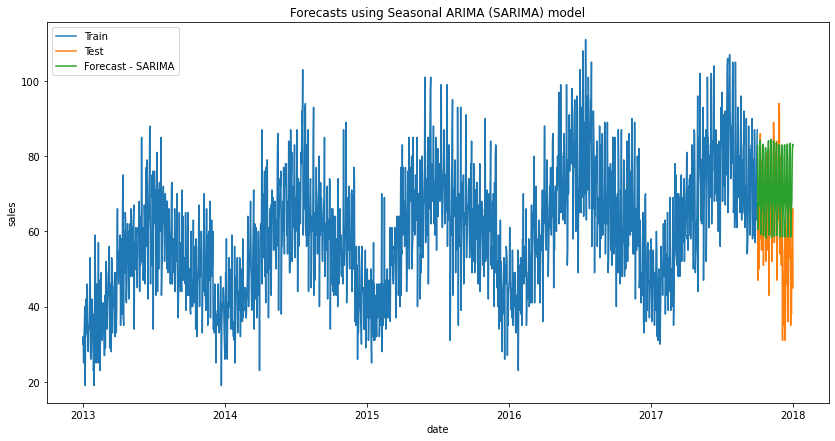

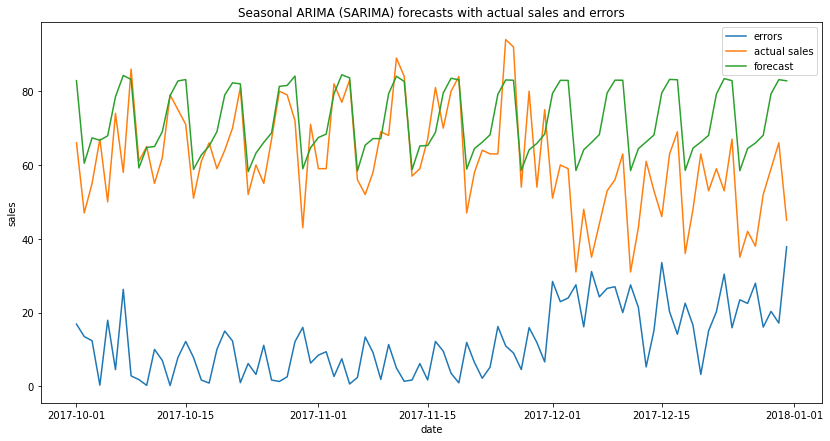

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,5662,6626.90531,-964.90531,12.242024,15.326838,19.891667


In [31]:
arima_test_item1['errors'] = arima_test_item1.sales - arima_test_item1.pred_sales
arima_test_item1.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_item1['date'], train_item1['sales'], label='Train')
plt.plot(arima_test_item1.index, arima_test_item1['sales'], label='Test')
plt.plot(arima_test_item1.index, arima_test_item1['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_item1.index, np.abs(arima_test_item1['errors']), label='errors')
plt.plot(arima_test_item1.index, arima_test_item1['sales'], label='actual sales')
plt.plot(arima_test_item1.index, arima_test_item1['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

result_item1_sarima = arima_test_item1.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_item1_sarima

**Inference:** The SARIMA model performed better prediction against the Holt Winter Triple Exponential Smoothing with MAPE of **19.89%** but did not outperform the benchmark set by the Seasonal Naive model.

### Model 4: Linear Regression

Linear regression is a very commonly used supervised machine learning algorithm which predicts the values of dependent variable (y) based on the independent variable (x).

In [32]:
reg_item1 = item1
reg_item1

,date,store,item,sales,year,month,day,weekday
894740,2013-01-01,1,50,30,2013,1,1,1
894741,2013-01-02,1,50,32,2013,1,2,2
894742,2013-01-03,1,50,25,2013,1,3,3
894743,2013-01-04,1,50,32,2013,1,4,4
894744,2013-01-05,1,50,35,2013,1,5,5
...,...,...,...,...,...,...,...,...
896561,2017-12-27,1,50,38,2017,12,27,2
896562,2017-12-28,1,50,52,2017,12,28,3
896563,2017-12-29,1,50,59,2017,12,29,4
896564,2017-12-30,1,50,66,2017,12,30,5


### Steps involved

(i) Feature engineering

(ii) Feature selection and model building

(iii) Model evaluation and making predictions

#### (i) Feature Engineering
This step falls under the data preprocessing phase wherein the features are extracted from the raw data and these features are used to create the forecast model.

Raw Data -> Cleaning & Transforming -> Features 

In [33]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_item1[lag_i] = reg_item1.sales.shift(i)
    
# Rolling window
reg_item1['rolling_mean'] = reg_item1.sales.rolling(window=7).mean()
reg_item1['rolling_max'] = reg_item1.sales.rolling(window=7).max()
reg_item1['rolling_min'] = reg_item1.sales.rolling(window=7).min()

reg_item1 = reg_item1.dropna(how='any', inplace=False)
reg_item1 = reg_item1.drop(['store', 'item'], axis=1)

# Splitting the series to predict the last 3 months of 2017
reg_item1 = reg_item1.set_index('date')
reg_train_item1 = reg_item1.loc[:'2017-09-30']                        
reg_test_item1 = reg_item1.loc['2017-10-01':]

#### (ii) Feature Selection & Modelling
In this step only the relevant and useful features are selected that is the noise in the data will be removed and then the model will be built to generate optimal results

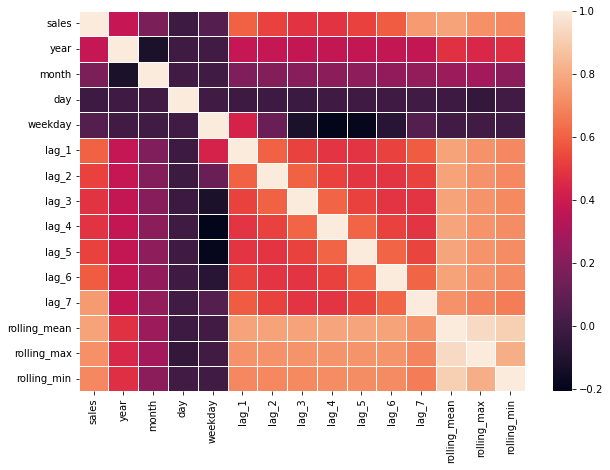

In [34]:
# Correlation matrix with heatmap
corr = reg_train_item1.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [35]:
X_train = reg_train_item1.drop(['sales'], axis=1)
y_train = reg_train_item1['sales'].values

X_test = reg_test_item1.drop(['sales'], axis=1)
y_test = reg_test_item1['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
item1_scores = pd.DataFrame(fit.scores_)
item1_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([item1_columns, item1_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # to name columns in the dataframe

# 5 best features
print(feature_scores.nlargest(5,'Score'))  

         Feature        Score
11  rolling_mean  2575.504056
10         lag_7  2230.012315
12   rolling_max  1918.513835
13   rolling_min  1641.474823
4          lag_1   986.901029


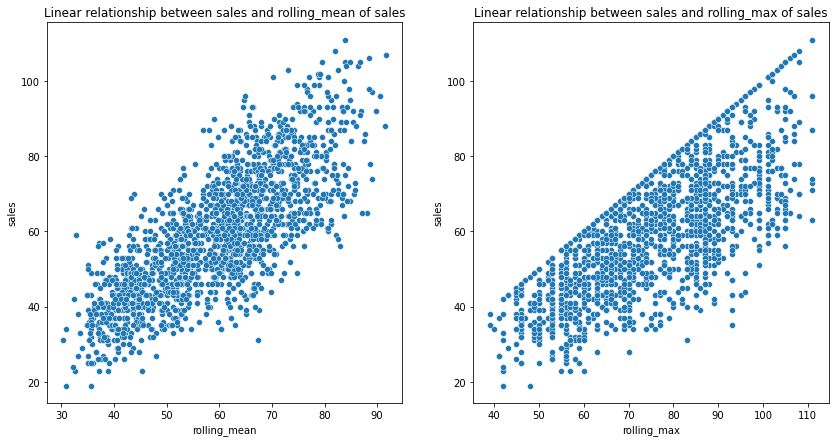

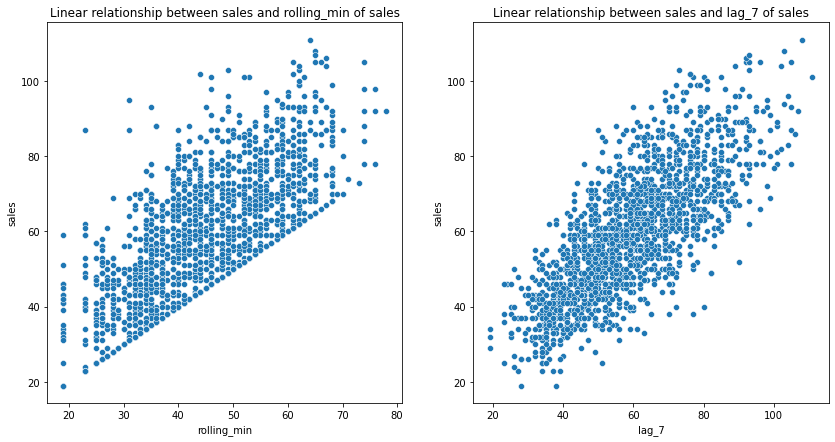

In [36]:
# Checking for a linear relationship of the top features with dependent variable (sales)

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_item1.rolling_mean, reg_train_item1.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(reg_train_item1.rolling_max, reg_train_item1.sales, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_item1.rolling_min, reg_train_item1.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(reg_train_item1.lag_7, reg_train_item1.sales, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [37]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_item1 = reg_test_item1[['sales']]
errors_item1['pred_sales'] = preds
errors_item1['errors'] = preds - y_test
errors_item1.insert(0, 'model', 'LinearRegression')

#### (iii) Building the regression model

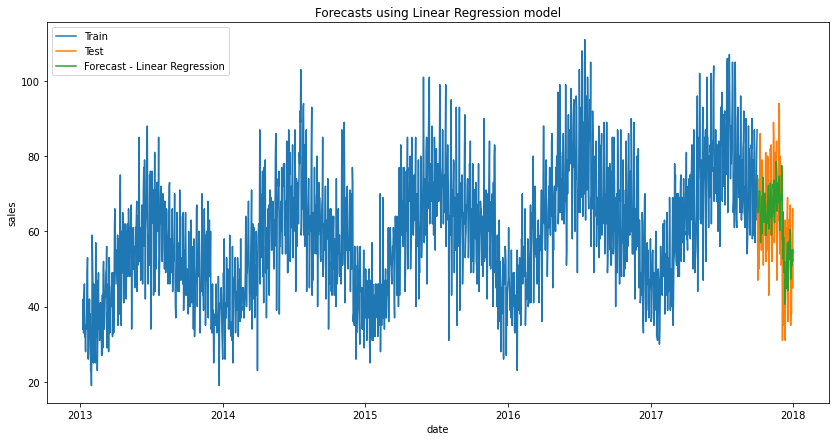

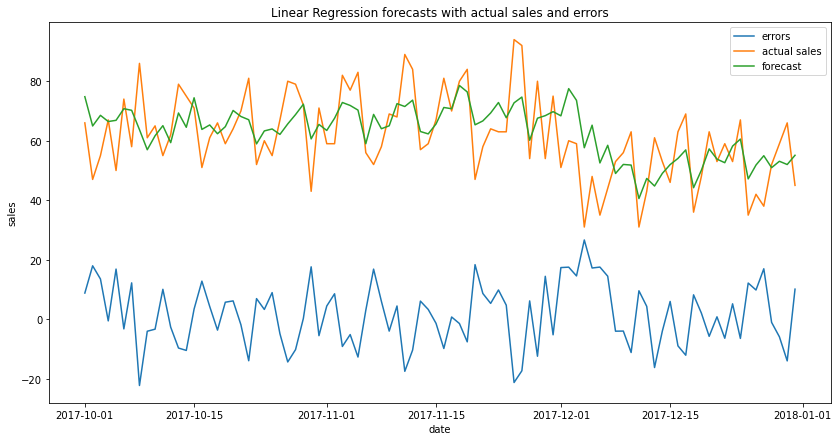

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,5662,5796.913448,134.913448,8.982619,10.671366,14.595566


In [38]:
# predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_item1.index, reg_train_item1['sales'], label='Train')
plt.plot(reg_test_item1.index, reg_test_item1['sales'], label='Test')
plt.plot(errors_item1.index, errors_item1['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_item1.index, errors_item1.errors, label='errors')
plt.plot(errors_item1.index, errors_item1.sales, label='actual sales')
plt.plot(errors_item1.index, errors_item1.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_item1_lr = errors_item1.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_item1_lr

**Inference:** The predictions made by linear regression resulted in mean absolute precentage error (MAPE) of **14.59%** which is better than the previously used models.

## Final Results and Conclusions

The sales record of item 50 from store 1 predicted using four different models which resulted in the following error: -

(i) Seasonal Naive: 18.17%

(ii) Holt-Winter's Triple Exponential Smoothing
   - Without damping trend: 26.64%
   - With damping trend: 21.59%
   
(iii) Seasonal ARIMA: 19.89%

(iv) Linear regression: 14.59%

The supervised machine learning algorithm Linear Regression outperformed the other prediction models accuaracy and it canbe concluded that the regresiion model is the most suitable for the sales data considered for the project. The reason behind regression being the most accurate among the other models lies in the assumption this algorithm takes that is the ***historical data will be repeated repeated in the future*** and because the dataset that was used for the project showed seasonality with linear trend, linear regression resulted in the most optimal prediction.